# Concepts

<img src = "https://deeplearning4j.org/img/GANs.png" width = 500>

<img src = "https://www.safaribooksonline.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0113.png" width = 500>

## Components
- Generator:
    - Input: Random Noise
    - Output: Image
    
    
- Discriminator:
    - Input: Real Image + Fake Image
    - Output: binary classifier (0/1)
 

## Training

- First Loop: Train discriminator
<img src= "https://cdn-images-1.medium.com/max/960/1*nAVqFluPijpBWR2tI4gCxg.png" width = 400>


- Second loop: Training generator
    - Note: target is 1 (Real)
<img src = "https://cdn-images-1.medium.com/max/960/1*VE1-kBwH_JwddgJXUgPyMQ.png" width = 400>

# Example

## Read in MNIST data

In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\shiwa\Downloads\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

### Plot function

In [36]:
def plot_20_digits(imgs):
    plt.figure(figsize=(5, 4))
    for i in range(20):
        img = imgs[i]
        plt.subplot(4, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

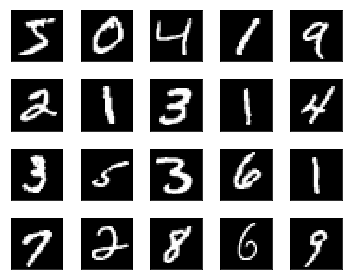

In [37]:
plot_20_digits(X_train[:20])

### Preprocess (Reshape and Scale)

In [3]:
def reshape_scale(x):
    y = x.reshape(-1, 784)
    y = np.float64(y)
    y = (y / 255 - 0.5) * 2
    y = np.clip(y, -1, 1)
    return y

In [4]:
X_train_ = reshape_scale(X_train)
X_train_.shape

(60000, 784)

In [5]:
X_test_ = reshape_scale(X_test)
X_test_.shape

(10000, 784)

### Revert reshape and scale

In [28]:
def de_reshape_scale(x):
    y = (x / 2 + 1) * 255
    y = np.clip(y, 0, 255)
    y = np.uint8(y)
    y = y.reshape(28, 28)
    return y

In [31]:
X = de_reshape_scale(X_train_[0])
X.shape

(28, 28)

### Get batch size X and Y

In [6]:
def real_batch_xy(data, batch_size, i):
    X = data[i*batch_size:(i+1)*batch_size]
    Y = np.ones([batch_size, 1])
    return X, Y

In [7]:
X, Y = real_batch_xy(X_train_, 64, 1)
X.shape, Y.shape

((64, 784), (64, 1))

Note: y label from 0 to 9 is useless here.

## Get eval size X and Y

In [8]:
def real_eval_xy(data, eval_size):
    random_index = np.random.choice(len(data), eval_size, replace=False)
    X = data[random_index]
    Y = np.ones([eval_size, 1])
    return X, Y  

In [9]:
X, Y = real_eval_xy(X_test_, 16)
X.shape, Y.shape

((16, 784), (16, 1))

## Generate Random Noise

Note: For simplicity, assume number of input neurons is hard-coded as 100

In [10]:
def generate_random_noise(num_examples, num_dim = 100):
    random_noises = np.random.normal(loc=0, scale=1, size = (num_examples, num_dim))  
    return random_noises

In [11]:
fake_data = generate_random_noise(1000)
fake_data.shape

(1000, 100)

### Get batch size X and Y

In [12]:
def fake_batch_xy(batch_size, generator_model):
    X = generate_random_noise(batch_size)
    X_img = generator_model.predict_on_batch(X)
    Y = np.zeros([batch_size, 1])
    return X, X_img, Y

In [38]:
X,  X_img, Y = fake_batch_xy(64, generator)
X.shape,  X_img.shape, Y.shape

((64, 100), (64, 784), (64, 1))

### Get eval size X and Y

same as batch

## Define Generator Network

In [14]:
generator = Sequential()
generator.add(Dense(128, activation='relu', input_dim=100))
generator.add(Dense(784, activation='tanh')) #scaled between -1 and 1
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
Total params: 114,064.0
Trainable params: 114,064
Non-trainable params: 0.0
_________________________________________________________________


## Define Discriminator Network

In [15]:
discriminator = Sequential()
discriminator.add(Dense(128, activation='relu', input_dim=784))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 100,609.0
Trainable params: 100,609
Non-trainable params: 0.0
_________________________________________________________________


In [16]:
discriminator.compile(optimizer='rmsprop',
              loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Define GAN network

In [17]:
GAN = Sequential()
GAN.add(generator)
GAN.add(discriminator)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 784)               114064    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 100609    
Total params: 214,673.0
Trainable params: 214,673
Non-trainable params: 0.0
_________________________________________________________________


In [18]:
GAN.compile(optimizer='rmsprop',
              loss='binary_crossentropy')

## Define Training parameters

In [24]:
NUM_EPOCH = 10
BATCH_SIZE = 64
EVAL_SIZE = 16
NUM_ITR = len(X_train_) // BATCH_SIZE

In [25]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

## Define Training Loop

- `fit`: Trains the model for a given number of epochs (iterations on a dataset).
- `train_on_batch`: Runs a single gradient update on a single batch of data.

In [26]:
losses = []
for epoch in range(NUM_EPOCH):

    for i in range(NUM_ITR):
        
        # 0. Prepare Inputs
        X_real, Y_real = real_batch_xy(X_train_, BATCH_SIZE, i)
        X_fake_raw, X_fake, Y_fake = fake_batch_xy(BATCH_SIZE, generator)
        
        # 1. Turn on Discriminator, train it with real AND fake
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_real, Y_real)
        discriminator.train_on_batch(X_fake, Y_fake)
        
        # 2. Turn off Discriminator, only train Generator with fake
        make_trainable(discriminator, False)
        GAN.train_on_batch(X_fake_raw, Y_real)
        
    # At the end of each epoch
    
    # 1. Generate evaluation set
    X_eval_real, Y_eval_real = real_eval_xy(X_test_, EVAL_SIZE)
    X_eval_raw, X_eval_fake, Y_eval_fake = fake_batch_xy(EVAL_SIZE, generator)
    
    # 2. use `test_on_batch` to return scalar loss
    d_loss  = discriminator.test_on_batch(X_eval_real, Y_eval_real) + \
              discriminator.test_on_batch(X_eval_fake, Y_eval_fake)
        
    g_loss = GAN.test_on_batch(X_eval_raw, Y_eval_real)
    
    losses.append((d_loss, g_loss))
    
    # 3. Print loss
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        epoch + 1, 
        NUM_EPOCH, 
        d_loss, 
        g_loss))

Epoch:   1/10 Discriminator Loss: 1.5504 Generator Loss: 0.2876
Epoch:   2/10 Discriminator Loss: 1.9726 Generator Loss: 0.1835
Epoch:   3/10 Discriminator Loss: 1.8195 Generator Loss: 0.2267
Epoch:   4/10 Discriminator Loss: 2.0343 Generator Loss: 0.1780
Epoch:   5/10 Discriminator Loss: 2.2179 Generator Loss: 0.1402
Epoch:   6/10 Discriminator Loss: 2.2347 Generator Loss: 0.1454
Epoch:   7/10 Discriminator Loss: 2.0926 Generator Loss: 0.1886
Epoch:   8/10 Discriminator Loss: 1.7749 Generator Loss: 0.2595
Epoch:   9/10 Discriminator Loss: 1.9330 Generator Loss: 0.2142
Epoch:  10/10 Discriminator Loss: 3.5078 Generator Loss: 0.0460


## Look at fake digits

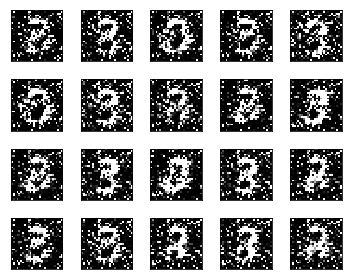

In [40]:
_, X_fake, _ = fake_batch_xy(20, generator)
fake_imgs = [de_reshape_scale(x) for x in X_fake]
plot_20_digits(fake_imgs)

# Ref
- https://towardsdatascience.com/understanding-generative-adversarial-networks-4dafc963f2ef
- https://deeplearning4j.org/generative-adversarial-network